In [1]:
import openpyxl
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("dataset.xlsx", sheet_name=None, header=0)
all_df = {}
for i, d in enumerate(df.items()):
    name, data = d
    data['wellid'] = i
    all_df[name] = data
data = pd.concat(df.values())
data = data[data['DEPTH'] == data["DEPTH"]]
data = data.reset_index()
data = data.drop(['index'], axis=1)

comb = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]
def label_facies(row):
    f = row['Fluid']
    lf = row['Log_Facies']
    return comb.index((f, lf))
data['MixLabel'] = data.apply(label_facies, axis=1)

In [3]:
 # change model here
CLF = LogisticRegression

In [4]:
Y =  data['Log_Facies'].values

In [5]:
X = data[["DEPTH", "DT", "GR", "LLD", "NPHI", "RHOB"]].values

In [6]:
# using cross well
cross_well = False
if cross_well:
    test_well_index = 2
    train_index = data[data['wellid']!=test_well_index].index
    test_index = data[data['wellid']==test_well_index].index
    indices = [[train_index, test_index]]
    
    
else:
    num_of_shuffler = 1
    shuffler1 = StratifiedShuffleSplit(n_splits=num_of_shuffler, test_size=0.1, random_state=1).split(X, Y)
    s1 = [x for x in shuffler1]
    indices = [(train_idx, validation_idx) for train_idx, validation_idx in s1]


In [7]:
X_train_old = X[indices[0][0]]
Y_train = Y[indices[0][0]]
X_test_old = X[indices[0][1]]
Y_test = Y[indices[0][1]]

### POWER

In [8]:
step = [-20+i*0.5 for i in range(81)]

In [9]:
def power_once(power):
    X_np = np.copy(X_train_old)
    a = [X_np]
    if power == 0:
        pass
    else:
        X_np_square = X_np ** power
        X_np_square = X_np_square[:,1:]
        a.append(X_np_square)
    X_all = np.hstack(a)
    
    ss = StandardScaler()
    X_train = ss.fit_transform(X_all)
    clf = CLF()
    clf.fit(X_train, Y_train)
    
    # test train data 
    Y_pred = clf.predict(X_train)
    total = Y_pred.shape[0]
    correct = Y_pred[Y_pred==Y_train].shape[0]
    print("on train, total: {}, correct: {}, rate: {:.4f}".format(total, correct, correct/total))
    
    X_np = np.copy(X_test_old)
    a = [X_np]
    if power == 0:
        pass
    else:
        X_np_square = X_np ** power
        X_np_square = X_np_square[:,1:]
        a.append(X_np_square)
    X_all = np.hstack(a)
    X_test = ss.fit_transform(X_all)
    
    Y_pred = clf.predict(X_test)
    total = Y_pred.shape[0]
    correct = Y_pred[Y_pred==Y_test].shape[0]
    print("on test {}, total: {}, correct: {}, rate: {:.4f}".format(power, total, correct, correct/total))
    return correct/total, correct, total, power

In [10]:
result = [power_once(p) for p in step]

on train, total: 4225, correct: 3448, rate: 0.8161
on test -20.0, total: 470, correct: 359, rate: 0.7638
on train, total: 4225, correct: 3451, rate: 0.8168
on test -19.5, total: 470, correct: 360, rate: 0.7660
on train, total: 4225, correct: 3451, rate: 0.8168
on test -19.0, total: 470, correct: 359, rate: 0.7638
on train, total: 4225, correct: 3451, rate: 0.8168
on test -18.5, total: 470, correct: 358, rate: 0.7617
on train, total: 4225, correct: 3449, rate: 0.8163
on test -18.0, total: 470, correct: 357, rate: 0.7596
on train, total: 4225, correct: 3447, rate: 0.8159
on test -17.5, total: 470, correct: 361, rate: 0.7681
on train, total: 4225, correct: 3447, rate: 0.8159
on test -17.0, total: 470, correct: 362, rate: 0.7702
on train, total: 4225, correct: 3448, rate: 0.8161
on test -16.5, total: 470, correct: 365, rate: 0.7766
on train, total: 4225, correct: 3450, rate: 0.8166
on test -16.0, total: 470, correct: 368, rate: 0.7830
on train, total: 4225, correct: 3452, rate: 0.8170
on t

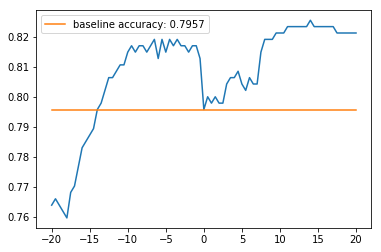

In [11]:
y = [i[0] for i in result]
x = [i[-1] for i in result]
plt.plot(x, y)
base = result[40][0]
plt.plot([-20, 20], [base, base], label='baseline accuracy: {:.4f}'.format(base) )
plt.legend()

In [12]:
from pprint import pprint
for i, c in enumerate(x):
    print(x[i], y[i], result[i], i)

-20.0 0.7638297872340426 (0.7638297872340426, 359, 470, -20.0) 0
-19.5 0.7659574468085106 (0.7659574468085106, 360, 470, -19.5) 1
-19.0 0.7638297872340426 (0.7638297872340426, 359, 470, -19.0) 2
-18.5 0.7617021276595745 (0.7617021276595745, 358, 470, -18.5) 3
-18.0 0.7595744680851064 (0.7595744680851064, 357, 470, -18.0) 4
-17.5 0.7680851063829788 (0.7680851063829788, 361, 470, -17.5) 5
-17.0 0.7702127659574468 (0.7702127659574468, 362, 470, -17.0) 6
-16.5 0.776595744680851 (0.776595744680851, 365, 470, -16.5) 7
-16.0 0.7829787234042553 (0.7829787234042553, 368, 470, -16.0) 8
-15.5 0.7851063829787234 (0.7851063829787234, 369, 470, -15.5) 9
-15.0 0.7872340425531915 (0.7872340425531915, 370, 470, -15.0) 10
-14.5 0.7893617021276595 (0.7893617021276595, 371, 470, -14.5) 11
-14.0 0.7957446808510639 (0.7957446808510639, 374, 470, -14.0) 12
-13.5 0.7978723404255319 (0.7978723404255319, 375, 470, -13.5) 13
-13.0 0.8021276595744681 (0.8021276595744681, 377, 470, -13.0) 14
-12.5 0.80638297872340

## SVM

In [13]:
CLF = SVC
step = [-20+i*0.5 for i in range(81)]
result = [power_once(p) for p in step]


on train, total: 4225, correct: 3625, rate: 0.8580
on test -20.0, total: 470, correct: 399, rate: 0.8489
on train, total: 4225, correct: 3624, rate: 0.8578
on test -19.5, total: 470, correct: 399, rate: 0.8489
on train, total: 4225, correct: 3627, rate: 0.8585
on test -19.0, total: 470, correct: 400, rate: 0.8511
on train, total: 4225, correct: 3626, rate: 0.8582
on test -18.5, total: 470, correct: 400, rate: 0.8511
on train, total: 4225, correct: 3625, rate: 0.8580
on test -18.0, total: 470, correct: 400, rate: 0.8511
on train, total: 4225, correct: 3626, rate: 0.8582
on test -17.5, total: 470, correct: 399, rate: 0.8489
on train, total: 4225, correct: 3627, rate: 0.8585
on test -17.0, total: 470, correct: 400, rate: 0.8511
on train, total: 4225, correct: 3625, rate: 0.8580
on test -16.5, total: 470, correct: 400, rate: 0.8511
on train, total: 4225, correct: 3625, rate: 0.8580
on test -16.0, total: 470, correct: 399, rate: 0.8489
on train, total: 4225, correct: 3626, rate: 0.8582
on t

on train, total: 4225, correct: 3636, rate: 0.8606
on test 19.5, total: 470, correct: 394, rate: 0.8383
on train, total: 4225, correct: 3637, rate: 0.8608
on test 20.0, total: 470, correct: 395, rate: 0.8404


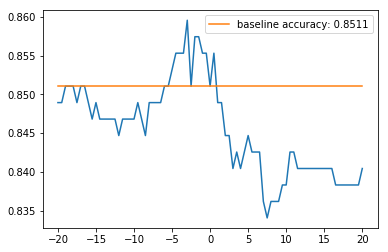

In [14]:
y = [i[0] for i in result]
x = [i[-1] for i in result]
plt.plot(x, y)
base = result[40][0]
plt.plot([-20, 20], [base, base], label='baseline accuracy: {:.4f}'.format(base) )
plt.legend()

In [15]:
from pprint import pprint
for i, c in enumerate(x):
    print(x[i], y[i], result[i], i)

-20.0 0.8489361702127659 (0.8489361702127659, 399, 470, -20.0) 0
-19.5 0.8489361702127659 (0.8489361702127659, 399, 470, -19.5) 1
-19.0 0.851063829787234 (0.851063829787234, 400, 470, -19.0) 2
-18.5 0.851063829787234 (0.851063829787234, 400, 470, -18.5) 3
-18.0 0.851063829787234 (0.851063829787234, 400, 470, -18.0) 4
-17.5 0.8489361702127659 (0.8489361702127659, 399, 470, -17.5) 5
-17.0 0.851063829787234 (0.851063829787234, 400, 470, -17.0) 6
-16.5 0.851063829787234 (0.851063829787234, 400, 470, -16.5) 7
-16.0 0.8489361702127659 (0.8489361702127659, 399, 470, -16.0) 8
-15.5 0.8468085106382979 (0.8468085106382979, 398, 470, -15.5) 9
-15.0 0.8489361702127659 (0.8489361702127659, 399, 470, -15.0) 10
-14.5 0.8468085106382979 (0.8468085106382979, 398, 470, -14.5) 11
-14.0 0.8468085106382979 (0.8468085106382979, 398, 470, -14.0) 12
-13.5 0.8468085106382979 (0.8468085106382979, 398, 470, -13.5) 13
-13.0 0.8468085106382979 (0.8468085106382979, 398, 470, -13.0) 14
-12.5 0.8468085106382979 (0.84